In [1]:

# let's just proof of concept the training loop of mcts RL through connect 4

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
import time

#### write game engine

In [2]:
'''
build the game engine
following: https://github.com/pbsinclair42/MCTS/blob/master/exampleInterfaces.py
'''

class game_engine_mcts():

    def __init__(self):
        self.board_width = 7
        self.board_height = 6
        self.board_state = np.zeros((self.board_height, self.board_width))
        self.currentPlayer =  1
        
    def getCurrentPlayer(self) -> int:
        ''' mcts required method '''
        return self.currentPlayer
    
    def getPossibleActions(self) -> np.ndarray:
        ''' mcts required method '''
        return np.where(self.board_state[-1] == 0)[0] # columns has open slot
    
    def isTerminal(self) -> bool:
        ''' mcts required method '''
        if len(self.getPossibleActions()) < 1:
            return True # it's a draw
        return bool(self._checkall())
    
    def getReward(self) -> int:
        ''' mcts required method '''
        _temp = self._checkall()
        return _temp * self.currentPlayer * -1
        
    def _calc_drop_loc(self, col_index :int) -> int:
        ''' simulates gravity '''
        # return lowest open position in this column
        mask = (self.board_state[:,col_index] == 0)
        return mask.argmax() 
        
    def _consecutive(self, data: np.ndarray) -> list:
        ''' groups consecutive runs  '''
        # from https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array
        return np.split(data, np.where(np.diff(data) != 1)[0]+1)

    def _checkall(self):
        ''' loop through each possible line and check if there's 4 in a row
        (could reduce this by only checking from where the peice was placed) '''
        _isterminal = False
        # check rows
        for i in range(6):
            _row = self.board_state[i]
            _isterminal += self._check_terminal(_row)
            
        # check columns
        for i in range(7):
            _col = self.board_state[:,i]
            _isterminal += self._check_terminal(_col)

        # check diagonals
        for offset in range(1,7):
            # this works by sliding the identity matrix across the board to select the diagonal, then tests it
            # (this could be cleaned up)
            mask = (np.eye(14)[4:4+self.board_height][:,offset:offset+self.board_width] == True)
            _isterminal += self._check_terminal(self.board_state[mask])

        for offset in range(1,7):
            mask = (np.rot90(np.eye(14))[4:4+self.board_height][:,offset:offset+self.board_width] == True)
            _isterminal += self._check_terminal(self.board_state[mask])
            
        self.game_over = bool(_isterminal)
        return _isterminal

            
    def _check_terminal(self, array):
        ''' given a 1D array, look for 4 in a row '''
        for _connect in self._consecutive(np.where(array == 1)[0]):
            if len(_connect) >= 4:
                return True
        for _connect in self._consecutive(np.where(array == -1)[0]):
            if len(_connect) >= 4:
                return True
        return False

    def takeAction(self, action):
        ''' mcts required method '''
        # take action, return copy of state
        
        if action in self.getPossibleActions():
            new_state = deepcopy(self)

            _drop_loc = new_state._calc_drop_loc(action)
            new_state.board_state[_drop_loc, action] = new_state.currentPlayer
            new_state.isTerminal()
            new_state.currentPlayer = self.currentPlayer * -1

            return new_state


#### mcts and tree nodes
Slightly modified to return the tree, which allows visualization of the number of visits and total reward for each child.

In [3]:
'''
from: https://github.com/pbsinclair42/MCTS/blob/master/mcts.py
modified mcts.search to return tree (allows visualization of children choices)
'''

# randomly selects a possible action
def randomPolicy(state):
    while not state.isTerminal():
        try:
            action = np.random.choice(state.getPossibleActions())
        except IndexError:
            raise Exception("Non-terminal state has no possible actions: " + str(state))
        state = state.takeAction(action)
    return state.getReward()


class treeNode():
    def __init__(self, state, parent):
        self.state = state
        self.isTerminal = state.isTerminal()
        self.isFullyExpanded = self.isTerminal
        self.parent = parent
        self.numVisits = 0
        self.totalReward = 0
        self.children = {}

    def __str__(self):
        s=[]
        s.append("totalReward: %s"%(self.totalReward))
        s.append("numVisits: %d"%(self.numVisits))
        s.append("isTerminal: %s"%(self.isTerminal))
        s.append("possibleActions: %s"%(self.children.keys()))
        return "%s: {%s}"%(self.__class__.__name__, ', '.join(s))

class mcts():
    def __init__(self,
                 timeLimit=None,
                 iterationLimit=None,
                 explorationConstant=1 / np.sqrt(2),
                 rolloutPolicy=randomPolicy):
        if timeLimit != None:
            if iterationLimit != None:
                raise ValueError("Cannot have both a time limit and an iteration limit")
            # time taken for each MCTS search in milliseconds
            self.timeLimit = timeLimit
            self.limitType = 'time'
        else:
            if iterationLimit == None:
                raise ValueError("Must have either a time limit or an iteration limit")
            # number of iterations of the search
            if iterationLimit < 1:
                raise ValueError("Iteration limit must be greater than one")
            self.searchLimit = iterationLimit
            self.limitType = 'iterations'
        self.explorationConstant = explorationConstant
        self.rollout = rolloutPolicy

    def search(self, initialState, needDetails=False):
        self.root = treeNode(initialState, None)

        if self.limitType == 'time':
            timeLimit = time.time() + self.timeLimit / 1000
            while time.time() < timeLimit:
                self.executeRound()
        else:
            for i in range(self.searchLimit):
                self.executeRound()

        bestChild = self.getBestChild(self.root, 0)
#        print('root',self.root)
        action=(action for action, node in self.root.children.items() if node is bestChild).__next__()
        if needDetails:
            return {"action": action, 
                    "expectedReward": bestChild.totalReward / bestChild.numVisits,
                    "tree": self.root # modification
                   }
        else:
            return action

    def executeRound(self):
        """
            execute a selection-expansion-simulation-backpropagation round
        """
        node = self.selectNode(self.root)
        reward = self.rollout(node.state)
        self.backpropogate(node, reward)

    def selectNode(self, node):
        while not node.isTerminal:
            if node.isFullyExpanded:
                node = self.getBestChild(node, self.explorationConstant)
            else:
                return self.expand(node)
        return node

    def expand(self, node):
        actions = node.state.getPossibleActions()
        for action in actions:
            if action not in node.children:
                newNode = treeNode(node.state.takeAction(action), node)
                node.children[action] = newNode
                if len(actions) == len(node.children):
                    node.isFullyExpanded = True
                return newNode

        raise Exception("Should never reach here")

    def backpropogate(self, node, reward):
        while node is not None:
            node.numVisits += 1
            node.totalReward += reward
            node = node.parent

    def getBestChild(self, node, explorationValue):
        bestValue = float("-inf")
        bestNodes = []
#        print(node.children.values())
        for child in node.children.values():
            nodeValue = node.state.getCurrentPlayer() * child.totalReward / child.numVisits + explorationValue * np.sqrt(
                2 * np.log(node.numVisits) / child.numVisits)
            if nodeValue > bestValue:
                bestValue = nodeValue
                bestNodes = [child]
            elif nodeValue == bestValue:
                bestNodes.append(child)
        return np.random.choice(bestNodes)

#### demonstration moves

We look at the outputs of the mcts algorithm and how it was used to select a move given a current game state.

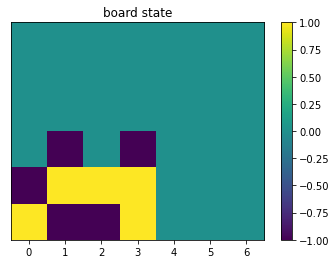

In [4]:
''' a single turn for demonstration/tutorial '''

# for visualization
norm = mpl.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# initialize game, initialize the mcts search
mcts_game = game_engine_mcts()
searcher = mcts(timeLimit=10000) # in milliseconds

# initialize board to a more interesting state for demonstration
mcts_game.board_state[0,0] = 1
mcts_game.board_state[0,1] = -1
mcts_game.board_state[0,2] = -1
mcts_game.board_state[0,3] = 1
mcts_game.board_state[1,0] = -1
mcts_game.board_state[1,1] = 1
mcts_game.board_state[1,2] = 1
mcts_game.board_state[1,3] = 1
mcts_game.board_state[2,1] = -1
mcts_game.board_state[2,3] = -1

plt.title('board state')
plt.imshow(mcts_game.board_state, origin='lower',norm=norm)
plt.yticks([])
plt.colorbar()

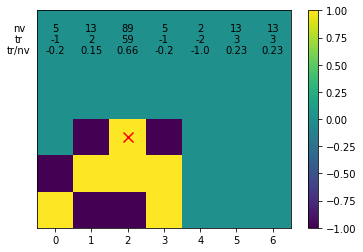

In [5]:
''' player 1 takes a turn '''
action_dict = searcher.search(initialState = mcts_game, needDetails=True)

# take best action
mcts_game = mcts_game.takeAction(action_dict['action'])

# plot the board state
plt.imshow(mcts_game.board_state, origin='lower',norm=norm)
plt.colorbar()

# identify the played move
plt.scatter(action_dict['action'],
            np.where(mcts_game.board_state[:,action_dict['action']] != 0)[0][-1],
            c='r',marker='x',s=100)

# loop over each visited child node, plot text for these 
for key in action_dict['tree'].children.keys():

    _treward = action_dict['tree'].children[key].totalReward
    _nvisits = action_dict['tree'].children[key].numVisits

    plt.text(int(key),5,_nvisits,
             horizontalalignment='center',
             verticalalignment='center')
    plt.text(int(key),5-0.3,_treward,
             horizontalalignment='center',
             verticalalignment='center')
    try:
        plt.text(int(key),5-0.6,f'{_treward/_nvisits:.2}',
                 horizontalalignment='center',
                 verticalalignment='center')
    except:
        pass

# plot titles
plt.text(-1,5,'nv', # n visits
         horizontalalignment='center',
         verticalalignment='center')
plt.text(-1,5-0.3,'tr', # reward
         horizontalalignment='center',
         verticalalignment='center')
plt.text(-1,5-0.6,'tr/nv', # n visits
         horizontalalignment='center',
         verticalalignment='center')
plt.yticks([]);


nv = Number of Visits to that node<br>
tr = Total Reward from visiting that node and rolling out games<br><br>
In the above figure, player 1 has selected the action that maximizes<br>
$\frac{Total Reward}{Number Visits}$. <br>
Some rewards are negative, indicating those moves rolled out into losses for this player.

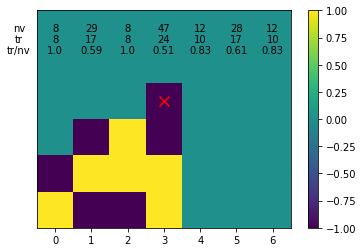

In [6]:
''' player 2 takes a turn '''
action_dict = searcher.search(initialState = mcts_game, needDetails=True)

# take best action
mcts_game = mcts_game.takeAction(action_dict['action'])

# plot the board state
plt.imshow(mcts_game.board_state, origin='lower',norm=norm)
plt.colorbar()
# identify the played move
plt.scatter(action_dict['action'],
            np.where(mcts_game.board_state[:,action_dict['action']] != 0)[0][-1],
            c='r',marker='x',s=100)

# loop over each visited child node, plot text for these 
for key in action_dict['tree'].children.keys():

    _treward = action_dict['tree'].children[key].totalReward
    _nvisits = action_dict['tree'].children[key].numVisits

    plt.text(int(key),5,_nvisits,
             horizontalalignment='center',
             verticalalignment='center')
    plt.text(int(key),5-0.3,_treward,
             horizontalalignment='center',
             verticalalignment='center')
    try:
        plt.text(int(key),5-0.6,f'{_treward/_nvisits:.2}',
                 horizontalalignment='center',
                 verticalalignment='center')
    except:
        pass

# plot titles
plt.text(-1,5,'nv', # n visits
         horizontalalignment='center',
         verticalalignment='center')
plt.text(-1,5-0.3,'tr', # reward
         horizontalalignment='center',
         verticalalignment='center')
plt.text(-1,5-0.6,'tr/nv', # n visits
         horizontalalignment='center',
         verticalalignment='center')
plt.yticks([]);



Player 2 responds with the move that $minimizes$ the $Total Reward$/$Number of Visits$.
Notice the number of visits to each node is very uneven.


#### Run a Full game

Due to chance in the mcts algorithm, the following game is non-deterministic. Saves each turn of the game into a folder for later inspection.

In [9]:
'''
plays a full game with both player using mcts for move selection
this saves an image of the game into a folder.
'''

assert True == False, 'Update the path to the save folder then delete this line!'

# initialize game, initialize the mcts search
mcts_game = game_engine_mcts()
searcher = mcts(timeLimit=20000) # in milliseconds

# mcts the full game
idx = 0
while not mcts_game.isTerminal():
    print(f'turn {idx}')
    idx +=1
    action_dict = searcher.search(initialState = mcts_game, needDetails=True)

    # take best action
    mcts_game = mcts_game.takeAction(action_dict['action'])

    # identify the played move
    plt.scatter(action_dict['action'],
                np.where(mcts_game.board_state[:,action_dict['action']] != 0)[0][-1],
                c='r',marker='x',s=100)

    plt.imshow(mcts_game.board_state, origin='lower',norm=norm)
    plt.colorbar()
    for key in action_dict['tree'].children.keys():

        _treward = action_dict['tree'].children[key].totalReward
        _nvisits = action_dict['tree'].children[key].numVisits
        
        plt.text(int(key),5,_nvisits,
                 horizontalalignment='center',
                 verticalalignment='center')
        plt.text(int(key),5-0.3,_treward,
                 horizontalalignment='center',
                 verticalalignment='center')
        try:
            plt.text(int(key),5-0.6,f'{_treward/_nvisits:.2}',
                     horizontalalignment='center',
                     verticalalignment='center')
        except:
            pass

    # plot titles
    plt.text(-1,5,'nv', # n visits
             horizontalalignment='center',
             verticalalignment='center')
    plt.text(-1,5-0.3,'tr', # reward
             horizontalalignment='center',
             verticalalignment='center')
    plt.text(-1,5-0.6,'tr/nv', # n visits
             horizontalalignment='center',
             verticalalignment='center')
    plt.yticks([])
    plt.savefig(f'/Users/Finn/desktop/c4_test/{idx:04}.png') # <<<<< change this!
    plt.close()
    
print(f'finished in {idx} moves.')

turn 0
turn 1
turn 2
turn 3
turn 4
turn 5
turn 6
turn 7
turn 8
turn 9
turn 10
turn 11
turn 12
turn 13
turn 14
turn 15
turn 16
turn 17
turn 18
turn 19
turn 20
turn 21
turn 22
turn 23
turn 24
turn 25
turn 26
turn 27
turn 28
turn 29
turn 30
turn 31
turn 32
turn 33
turn 34
turn 35
turn 36
finished in 37 moves.


#### Final thoughts
Because this does a random rollout and it's limited to 10 seconds per move, this can only get so accurate. (And I've seen some objectively poor moves).

I believe the idea is the "randomPolicy" is replaced with an RL agent, so the model gets better and makes rollout iteratively better.

(-1.0, 1.0)

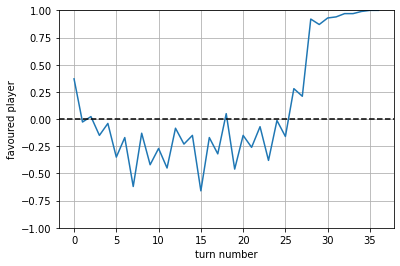

In [13]:
# tr/nv from a really close game
a = [0.37, -0.027, 0.023, -0.15,
     -0.04,-0.35,-0.17,-0.62,
     -0.13,-0.42,-0.27,-0.45,
     -0.084,-0.23,-0.15,-0.66,
     -0.17,-0.32,0.05,-0.46,
     -0.15,-0.26,-0.07,-0.38,
     -0.013,-0.16,0.28,0.21,
     0.92,0.87,0.93,0.94,
     0.97,0.97,0.99,1,
     1]
     
plt.plot(a)
plt.axhline(0,ls='--',c='k')
plt.grid()
plt.xlabel('turn number')
plt.ylabel('favoured player')
plt.ylim(-1,1)